### Compare MC methods
***Modeling Two-Component Gaussian Mixture Distribution***
#### 1. single parameter posterior simulation (weights)
(1) importance sampling 

(2) rejection sampling 

(3) Metropolis-Hasting sampling 

    a. long burn-out with single chain
    
    b. medium burn-out with 4 chains
    
    c. short burn-out with 10 chains
    
#### 2. five parameters posterior simulation (means, stds, weights)
(1) importance sampling 

(2) Metropolis-Hasting sampling 

(3) Hamiltonian sampling 

(4) automatic-differentiation variational inference method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import logsumexp
from scipy.stats import norm, cauchy, laplace, invgamma, dirichlet, beta, multivariate_normal, gaussian_kde, uniform, halfnorm
from functools import partial
import time
import pymc3 as pm
import theano.tensor as tt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
import multiprocessing
import arviz as az
from tqdm import tqdm
import time

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print("Number of cpu cores: ", multiprocessing.cpu_count())

Number of cpu cores:  8


# Generate Underlying Distribution

**Gaussian Mixture Model of 2 Components**

This distribution generates data by randomly sampling from one of the gaussian distribution

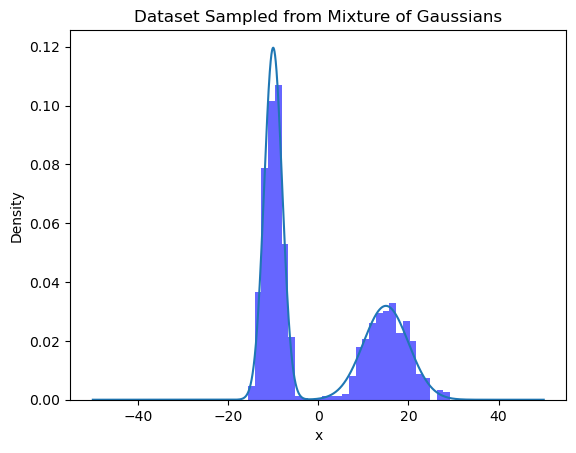

In [236]:
# Set seed for reproducibility
np.random.seed(20)

# Define parameters for the mixture model
mu1 = -10.0
std1 = 2.0
mu2 = 15.0
std2 = 5.0
weight1 = 0.6
weight2 = 0.4

# Generate the dataset from the mixture model
n_samples = 1000
X1 = []
for i in range(n_samples):
    rand_num = np.random.rand()
    if rand_num < weight1:
        sample = np.random.normal(mu1, std1)
    else:
        sample = np.random.normal(mu2, std2)
    X1.append(sample)

value = np.linspace(-50, 50, 10000)
pdf = weight1 * norm.pdf(value, loc=mu1, scale=std1) + weight2 * norm.pdf(value, loc=mu2, scale=std2)

# Plot the dataset
plt.hist(X1, bins=30, density=True, alpha=0.6, color='b')
plt.plot(value, pdf)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Dataset Sampled from Mixture of Gaussians')
plt.show()

# Monte Carlo Sampling Methods
## Target Posterior Distribution Case 1

In [227]:
# for case 1, fixed mus and stds. The only parameter is theta representing the weight of the first gaussian dist.
mu1 = -10.0
std1 = 2.0
mu2 = 15.0
std2 = 5.0

# prior follows a beta dist.
def log_prior_1(theta):
    return beta.logpdf(theta, a=2, b=2)

def log_likelihood_1(X, theta):
    prob = theta * norm.pdf(X, loc=mu1, scale=std1) + (1-theta) * norm.pdf(X, loc=mu2, scale=std2)
    return np.sum(np.log(prob + np.finfo(float).eps)) # smoothing

def log_semi_posterior_1(theta, X):
    if 0 < theta < 1:
        return log_prior_1(theta) + log_likelihood_1(X, theta)
    else:
        return -np.inf

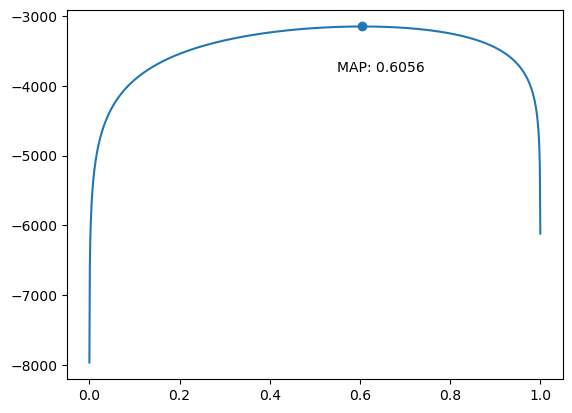

In [228]:
space = np.linspace(0.0001,0.9999,1000)
y = np.array([log_semi_posterior_1(theta, X1) for theta in space])
mode_y = np.argmax(y)
plt.plot(space, y)
plt.scatter(space[mode_y], y[mode_y])
plt.text(0.55, -3800, f'MAP: {space[mode_y]:.4f}')
plt.show()

### Importance Sampling

In [4]:
class importance():
    def __init__(self, P):
        '''
        Parameters
            P: log-semi-posterior to approximate, should be a function holder partial(my_func, arg1, arg2)
            Q: sampler distribution using predefined dist. from scipy
        '''
        self.P = P
    
    def gen_samples(self, n_samples, Q, **kargs):
        
        Q = Q(**kargs)
        self.samples = Q.rvs(size=n_samples)
        if self.samples.ndim > 1:
            Px = [self.P(*s) for s in self.samples]
        else:
            Px = [self.P(s) for s in self.samples]
        Qx = Q.logpdf(self.samples)
        log_w = Px - Qx
        self.log_w = log_w
        self.norm_w = np.exp(log_w - logsumexp(log_w))
        
    
    def pred_exp(self):
        '''
        predict posterior expectation
        '''        
        return self.norm_w @ self.samples

    def pred_mode(self):
        '''
        predict posterior max
        '''
        ind = np.argmax(self.norm_w)
        return self.samples[ind]
    
    def plot_n_to_accuracy(self, n_list, **kargs):
        assert len(self.samples.shape) == 1, 'This method only works on 1d parameter space'
        expect = []
        mode = []
        for n in n_list:
            self.gen_samples(int(n), norm, **kargs)
            expect.append(self.pred_exp())
            mode.append(self.pred_mode())

        plt.figure(figsize=(10,5))
        plt.plot(n_list, expect, color='navy', label='Expectation')
        plt.scatter(n_list, expect, color='navy')
        plt.plot(n_list, mode, color='orange', label='Mode')
        plt.scatter(n_list, mode, color='orange')
        plt.hlines(0.6, xmin=0, xmax=n_list[-1],label='true theta', color='gray', alpha=0.5)
        plt.title('theta esitmation using importance sampling')
        plt.xlabel('number of samples')
        plt.xscale('log')
        plt.ylabel('estimation value')
        plt.legend()
        plt.show()

In [5]:
# test importance sampling function
np.random.seed(20)
P = partial(log_semi_posterior_1, X=X1)
model = importance(P)
kargs = {'loc':0, 'scale':1}
model.gen_samples(1000000, norm, **kargs)
print(model.pred_exp())
print(model.pred_mode())

0.6050929230646628
0.6054663556828637


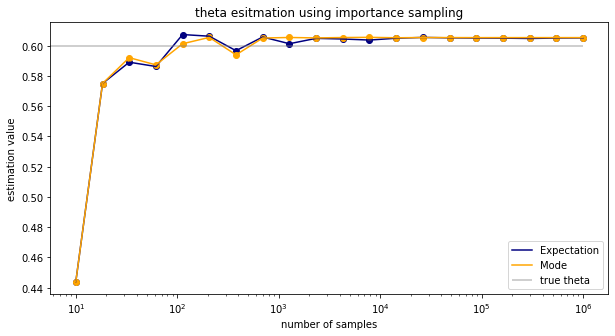

In [8]:
n_list = np.logspace(1, 6, 20)
model.plot_n_to_accuracy(n_list)

### Rejection Sampling

In [194]:
class rejection():
    def __init__(self, P, samples=None, norm_w=None):
        '''
        Parameters
            P: log-semi-posterior to approximate, should be a function holder partial(my_func, arg1, arg2)
            Q: sampler distribution using predefined dist. from scipy
        '''
        self.P = P
        self.samples = samples
    
    def gen_samples(self, n_samples, Q, log_c=1.0, print_round=True, **kargs):
        Q = Q(**kargs)
        self.log_c = log_c
        self.samples = np.empty((0,))
        i = 0
        n = 0
        multi_dim = Q.rvs(size=1).ndim > 1
        while i < n_samples:
            sample = Q.rvs(size=1)

            if multi_dim:
                Px = self.P(*sample)
            else:
                Px = self.P(sample)

            u = np.random.uniform(0, 1)
            log_accept_rate = Px - Q.logpdf(sample) - log_c if Px > -np.inf else -np.inf
            
            if print_round:
                print(f"Sample: {sample}, Px: {Px}, log_c: {log_c}, log_accept_rate: {log_accept_rate}, u: {u},log_u:{np.log(u)}")  # Debugging line

            if np.log(u) <= log_accept_rate and log_accept_rate < 0:
                self.samples = np.append(self.samples, sample)
                i += 1

            n += 1  # update total sample count

            if n == n_samples:
                print(f'acceptance rate: {i/n}')
                if i/n <= 0.5:
                    print('too low!')
                    break
        
    
    def pred_exp(self):
        '''
        predict posterior expectation
        '''        
        return np.mean(self.samples)

    def pred_mode(self):
        '''
        predict posterior max (MAP) with gaussian KDE
        '''
        kde = gaussian_kde(self.samples)
        x_vals = np.linspace(min(self.samples), max(self.samples), 1000)
        density_vals = kde(x_vals)
        return x_vals[np.argmax(density_vals)]
    
    def plot_n_to_accuracy(self, n_list, **kargs):
        assert len(self.samples.shape) == 1, 'This method only works on 1d parameter space'
        expect = []
        mode = []
        for n in n_list:
            self.gen_samples(int(n), norm, log_c = self.log_c, print_round=False, **kargs)
            expect.append(self.pred_exp())
            mode.append(self.pred_mode())

        plt.figure(figsize=(10,5))
        plt.plot(n_list, expect, color='navy', label='Expectation')
        plt.scatter(n_list, expect, color='navy')
        plt.plot(n_list, mode, color='orange', label='Mode')
        plt.scatter(n_list, mode, color='orange')
        plt.hlines(0.6, xmin=0, xmax=n_list[-1],label='true theta', color='gray', alpha=0.5)
        plt.title('theta esitmation using rejection sampling')
        plt.xlabel('number of samples')
        plt.xscale('log')
        plt.ylabel('estimation value')
        plt.legend()
        plt.show()

In [197]:
# test rejection sampling function
np.random.seed(20)
P = partial(log_semi_posterior_1, X=X1)
model = rejection(P)
kargs = {'a':1.1, 'b':1.1}
model.gen_samples(10, beta, log_c=-3200, print_round=True, **kargs)

Sample: [0.99914324], Px: [-5270.18915875], log_c: -3200, log_accept_rate: [-2069.67952954], 0.2723164020665839,log_u:-1.3007906458370826
Sample: [0.54536527], Px: [-3159.17872895], log_c: -3200, log_accept_rate: [40.76403474], 0.03666430642108576,log_u:-3.305951574263714
Sample: [0.72562771], Px: [-3185.64660172], log_c: -3200, log_accept_rate: [14.31810469], 0.8576255311697625,log_u:-0.15358771862160192
Sample: [0.36894034], Px: [-3266.41873227], log_c: -3200, log_accept_rate: [-66.4696771], 0.4923810396145495,log_u:-0.7085023914762756
Sample: [0.64065593], Px: [-3154.52917315], log_c: -3200, log_accept_rate: [45.42100826], 0.6794111175532508,log_u:-0.386528859607892
Sample: [0.05398991], Px: [-4270.30318026], log_c: -3200, log_accept_rate: [-1070.2024266], 0.4809841322996459,log_u:-0.7319209984025495
Sample: [0.99168379], Px: [-4377.38607854], log_c: -3200, log_accept_rate: [-1177.1029809], 0.62685343771635,log_u:-0.4670425173219556
Sample: [0.01261376], Px: [-5132.27481212], log_c:

In [167]:
model.pred_mode()

0.0036591020014813476

In [ ]:
n_list = np.logspace(1, 6, 10)
model.plot_n_to_accuracy(n_list)

### Metroplolis-Hasting Sampling

In [145]:
class MH():
    def __init__(self, P, initial_state):
        self.P = P
        self.current_state = initial_state
           
    def gen_samples(self, n_samples, Q, burn_in='long', **kargs):
        self.Q = Q
        self.kargs = kargs
        self.samples = []
        self.accepted_moves = 0
        self.total_moves = 0            

        if burn_in == 'long':
            burn_in_samples = int(n_samples * 0.4)
            self._run_chain(n_samples, burn_in_samples)

        elif burn_in == 'medium':
            for _ in range(4):
                self.current_state = np.random.uniform(0,1, size=self.current_state.shape)
                burn_in_samples = int(n_samples * 0.1)
                self._run_chain(n_samples // 4, burn_in_samples)

        elif burn_in == 'short':
            for _ in range(n_samples):
                self.current_state = np.random.uniform(0,1, size=self.current_state.shape)
                burn_in_samples = 10
                self._run_chain(1, burn_in_samples)
        
        self.samples = np.array(self.samples)

    def _run_chain(self, n_samples, burn_in_samples):
        for _ in range(burn_in_samples):
            self._step(burnt=True)
        for i in range(n_samples):
            self._step(burnt=False)
            self.samples.append(self.current_state.copy())

    def _step(self, burnt=False):
        new_state = self.Q.rvs(**self.kargs)

        # Calculate the acceptance probability
        if type(new_state) == np.ndarray:
            log_a = min(0, self.P(*new_state) - self.P(*self.current_state))
        else:
            log_a = min(0, self.P(new_state) - self.P(self.current_state))

        # Accept or reject the candidate
        if np.log(np.random.rand()) < log_a:
            self.current_state = new_state
            self.accepted_moves += 1 if not burnt else 0
        self.total_moves += 1 if not burnt else 0
    
    def get_acceptance_rate(self):
        return self.accepted_moves / self.total_moves
    
    def pred_exp(self):
        return np.mean(self.samples, axis=0)

    def pred_mode(self):
        # This function is only appropriate for univariate distributions
        if type(self.current_state) == np.ndarray:
            raise ValueError("The method 'pred_mode' is not applicable for multivariate distributions.")
        else:
            kde = gaussian_kde(self.samples)
            x_vals = np.linspace(min(self.samples), max(self.samples), 1000)
            density_vals = kde(x_vals)
            return x_vals[np.argmax(density_vals)]
    
    def plot_result(self, n_list, estimation):
        '''
        Parameters
            estimation: 'expectation' or 'MAP'
        '''
        assert len(self.samples.shape) == 1, 'This method only works on 1d parameter space'
        fig, ax = plt.subplots(1, 2, figsize=(16,5))
        ax[0].set_title(f'theta esitmation with {estimation} using Metropolis-Hasting sampling')
        ax[0].set_xlabel('number of samples')
        ax[0].set_xscale('log')
        ax[0].set_ylabel('estimation value')
        ax[0].hlines(0.6, xmin=0, xmax=n_list[-1],label='true theta', color='gray', alpha=0.5)

        
        ax[1].set_title(f'Computation time with {estimation} using Metropolis-Hasting sampling')
        ax[1].set_xlabel('number of samples')
        ax[1].set_xscale('log')
        ax[1].set_ylabel('seconds')
        
        for method in ['long', 'medium', 'short']:
            expect = []
            timer = []
            for n in n_list:
                start = time.time()
                self.gen_samples(int(n), self.Q, burn_in=method)
                end = time.time()
                if estimation == 'expectation':
                    temp = self.pred_exp()
                elif estimation == 'MAP':
                    temp = self.pred_mode()
                expect.append(temp)
                timer.append(end-start)
                print(f'strategy: {method}, n: {n} done')
            ax[0].plot(n_list, expect, label=method)
            ax[0].scatter(n_list, expect)
            ax[0].legend()
            
            ax[1].plot(n_list, timer, label=method) 
            ax[1].scatter(n_list, timer)
            ax[1].legend()
        plt.tight_layout()
        plt.show()

In [91]:
# test MH sampling function
np.random.seed(20)
P = partial(log_semi_posterior_1, X=X1)
kargs = {'loc':0, 'scale':1}
model = MH(P)
model.gen_samples(1000, norm, burn_in='long', **kargs)
print(model.pred_exp())
print(model.pred_mode())

0.6036525493762271
0.6018667235695099


strategy: long, n: 10.0 done
strategy: long, n: 27.825594022071243 done
strategy: long, n: 77.4263682681127 done
strategy: long, n: 215.44346900318823 done
strategy: long, n: 599.4842503189409 done
strategy: long, n: 1668.100537200059 done
strategy: long, n: 4641.588833612777 done
strategy: long, n: 12915.496650148827 done
strategy: long, n: 35938.13663804626 done
strategy: long, n: 100000.0 done
strategy: medium, n: 10.0 done
strategy: medium, n: 27.825594022071243 done
strategy: medium, n: 77.4263682681127 done
strategy: medium, n: 215.44346900318823 done
strategy: medium, n: 599.4842503189409 done
strategy: medium, n: 1668.100537200059 done
strategy: medium, n: 4641.588833612777 done
strategy: medium, n: 12915.496650148827 done
strategy: medium, n: 35938.13663804626 done
strategy: medium, n: 100000.0 done
strategy: short, n: 10.0 done
strategy: short, n: 27.825594022071243 done
strategy: short, n: 77.4263682681127 done
strategy: short, n: 215.44346900318823 done
strategy: short, n: 

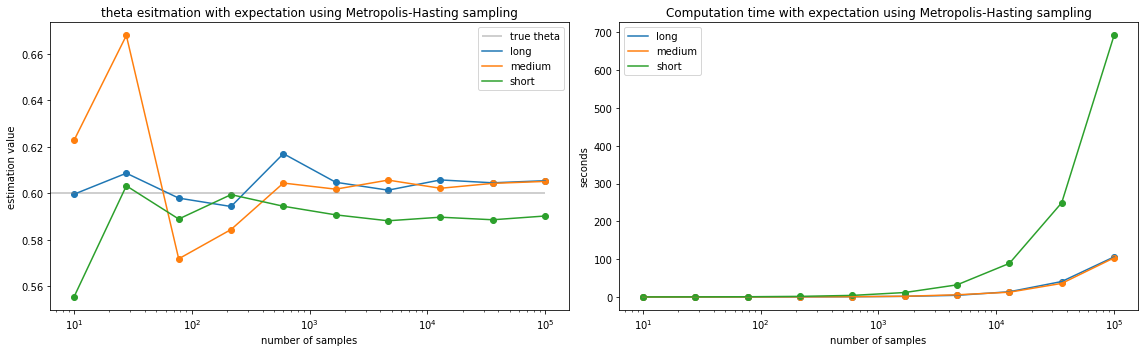

In [330]:
n_list = np.logspace(1, 5, 10)
model.plot_result(n_list, estimation='expectation')

strategy: long, n: 10.0 done
strategy: long, n: 27.825594022071243 done
strategy: long, n: 77.4263682681127 done
strategy: long, n: 215.44346900318823 done
strategy: long, n: 599.4842503189409 done
strategy: long, n: 1668.100537200059 done
strategy: long, n: 4641.588833612777 done
strategy: long, n: 12915.496650148827 done
strategy: long, n: 35938.13663804626 done
strategy: long, n: 100000.0 done
strategy: medium, n: 10.0 done
strategy: medium, n: 27.825594022071243 done
strategy: medium, n: 77.4263682681127 done
strategy: medium, n: 215.44346900318823 done
strategy: medium, n: 599.4842503189409 done
strategy: medium, n: 1668.100537200059 done
strategy: medium, n: 4641.588833612777 done
strategy: medium, n: 12915.496650148827 done
strategy: medium, n: 35938.13663804626 done
strategy: medium, n: 100000.0 done
strategy: short, n: 10.0 done
strategy: short, n: 27.825594022071243 done
strategy: short, n: 77.4263682681127 done
strategy: short, n: 215.44346900318823 done
strategy: short, n: 

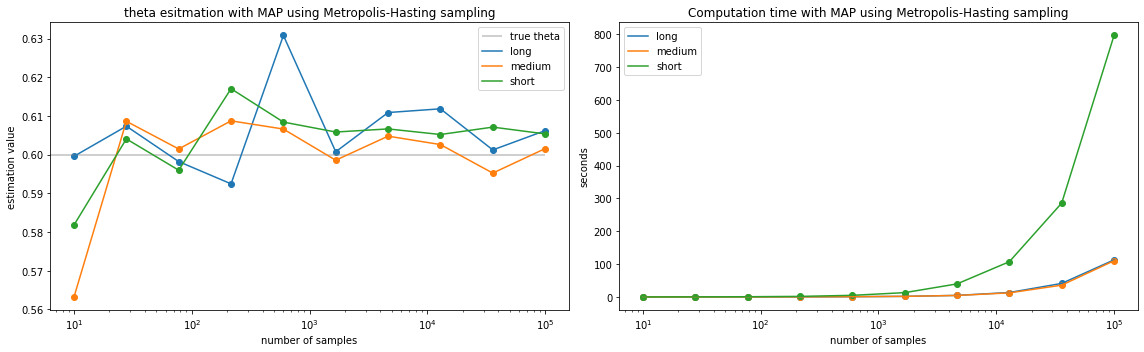

In [7]:
n_list = np.logspace(1, 5, 10)
model.plot_result(n_list, estimation='MAP')

## Target Posterior Distribution Case 2

In [1]:
# for case 2, I'll work in 5 dimensional space, where both means , both vairances and weights are parameters.

# prior follows a beta dist.
def log_prior_2(theta, mu1, std1, mu2, std2):
    prob_theta = beta.logpdf(theta, a=2, b=2)
    prob_mu1 = norm.logpdf(mu1, loc=0, scale=1)
    prob_mu2 = norm.logpdf(mu2, loc=0, scale=1)
    prob_std1 = halfnorm.logpdf(std1, scale=2)
    prob_std2 = halfnorm.logpdf(std2, scale=2)
    
    # return the joint dist of prior assuming indepence between parameters
    return np.sum([prob_theta, prob_mu1, prob_mu2, prob_std1, prob_std2]) 
    
def log_likelihood_2(X, theta, mu1, std1, mu2, std2):
    prob = theta * norm.pdf(X, loc=mu1, scale=std1) + (1-theta) * norm.pdf(X, loc=mu2, scale=std2)
    return np.sum(np.log(prob + np.finfo(float).eps)) # smoothing

def log_semi_posterior_2(theta, mu1, std1, mu2, std2, X):
    prior_prob = log_prior_2(theta, mu1, std1, mu2, std2)
    if prior_prob > -np.inf:
        return prior_prob + log_likelihood_2(X, theta, mu1, std1, mu2, std2)
    else:
        return -np.inf

### Importance Sampling

In [ ]:
np.random.seed(20)
P = partial(log_semi_posterior_2, X=X1)
model = importance(P)
kargs = {'mean':np.array([0, 0.5, 0.5, 1, 1]), 'cov':np.eye(5)}
start = time.time()
model.gen_samples(1000000, multivariate_normal, **kargs)
end = time.time()
print(model.pred_exp())
print(model.pred_mode())
print(f'process time: {end - start} seconds')

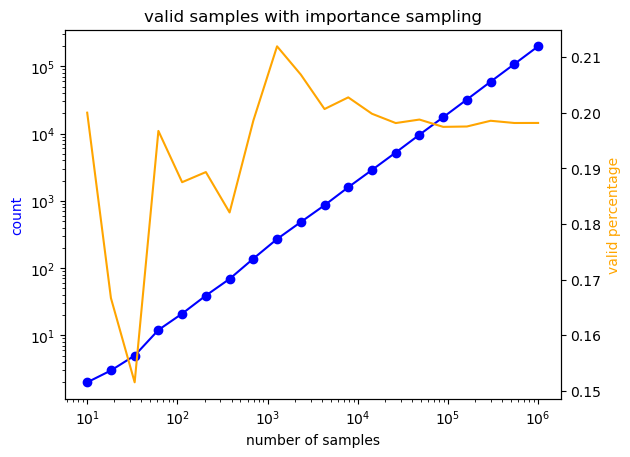

In [159]:
n_list = np.logspace(1, 6, 20)
valid_samples = []
per = []
for i in n_list:
    v = np.count_nonzero(model.log_w[:int(i)] != -np.inf)
    valid_samples.append(v)
    per.append(v/int(i))

fig, ax1 = plt.subplots()
ax1.plot(n_list, valid_samples, color='blue')
ax1.scatter(n_list, valid_samples, color='blue')
ax1.set_xlabel('number of samples')
ax1.set_xscale('log')
ax1.set_ylabel('count', color='blue')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(n_list, per, color='orange')
ax2.set_ylabel('valid percentage', color='orange')

plt.title('valid samples with importance sampling')
plt.show()

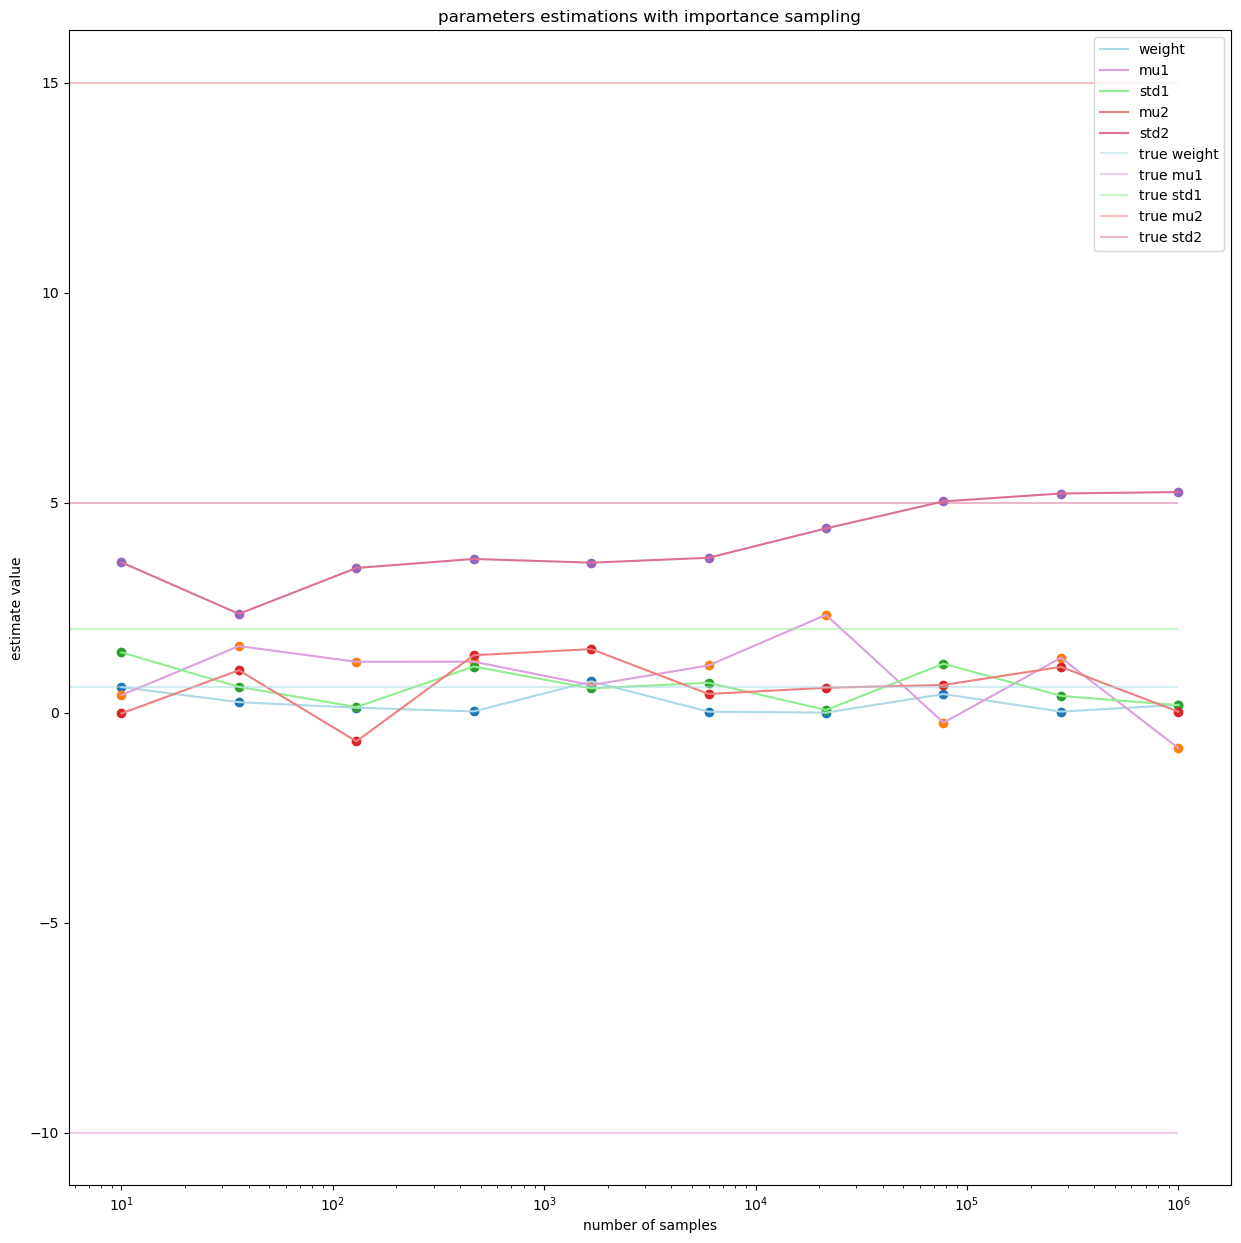

In [136]:
n_list = np.logspace(1, 6, 10)
result = np.zeros((10, 5))
P = partial(log_semi_posterior_2, X=X1)
model = importance(P)
kargs = {'mean':np.array([0, 0.5, 0.5, 1, 1]), 'cov':np.eye(5)}
for i in range(10):
    model.gen_samples(int(n_list[i]), multivariate_normal, **kargs)
    result[i] = model.pred_mode()
plt.figure(figsize=(15,15))
plt.plot(n_list, result[:,0], label='weight', color='lightblue')
plt.scatter(n_list, result[:,0])
plt.plot(n_list, result[:,1], label='mu1', color='plum')
plt.scatter(n_list, result[:,1])
plt.plot(n_list, result[:,2], label='std1', color='lightgreen')
plt.scatter(n_list, result[:,2])
plt.plot(n_list, result[:,3], label='mu2', color='lightcoral')
plt.scatter(n_list, result[:,3])
plt.plot(n_list, result[:,4], label='std2', color='palevioletred')
plt.scatter(n_list, result[:,4])
plt.title('parameters estimations with importance sampling')
plt.xlabel('number of samples')
plt.xscale('log')
plt.ylabel('estimate value')
plt.hlines(0.6, xmin=0, xmax=n_list[-1],label='true weight', color='lightblue', alpha=0.5)
plt.hlines(-10, xmin=0, xmax=n_list[-1],label='true mu1', color='plum', alpha=0.5)
plt.hlines(2, xmin=0, xmax=n_list[-1],label='true std1', color='lightgreen', alpha=0.5)
plt.hlines(15, xmin=0, xmax=n_list[-1],label='true mu2', color='lightcoral', alpha=0.5)
plt.hlines(5, xmin=0, xmax=n_list[-1],label='true std2', color='palevioletred', alpha=0.5)
plt.legend()
plt.show()

In [14]:
mean = np.array([0, 0, 0])  # Mean vector
cov = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
multi_norm = multivariate_normal(mean, cov)
s = multi_norm.rvs(size=10)
print(s)
print(multi_norm.pdf(s))

[[ 1.02340804 -0.50770965 -0.20847889]
 [-1.51312464 -0.29152757 -0.18573068]
 [-1.50578279  0.09240212 -0.44965768]
 [ 0.30042432  0.58203306 -0.07618323]
 [-0.84774733 -0.34891106 -1.32301057]
 [-0.68893221 -0.58714953  0.43300235]
 [ 1.62969706  0.41058864 -0.83046235]
 [ 1.07491053 -1.08676374  0.40109622]
 [-0.50011686  0.39482929 -0.2398224 ]
 [-0.35111353 -0.58860298 -0.31313904]]
[0.03235089 0.01903776 0.01839141 0.05108695 0.01738406 0.03837891
 0.01095568 0.0182152  0.05035907 0.0478009 ]


### Metropolis Hasting Sampling

In [157]:
# test MH sampling function
np.random.seed(20)
P = partial(log_semi_posterior_2, X=X1)
kargs = {'mean':np.array([0.5, 0, 10, 0, 10]), 'cov':np.diag([1, 1, 1, 1, 1])}
model = MH(P, initial_state=np.zeros(5))
model.gen_samples(10000, multivariate_normal, burn_in='long', **kargs)
print(model.pred_exp())
print(f'acceptance rate: {model.get_acceptance_rate()}')

[ 0.78473968 -0.3323786  11.87492547 -0.18440492 10.15281768]
acceptance rate: 0.0007


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta]
>Metropolis: [std2]
>Metropolis: [mu2]
>Metropolis: [std1]
>Metropolis: [mu1]


C:\Users\HP\Anaconda3\lib\site-packages\pymc3\step_methods\metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 100 tune and 10_000 draw iterations (100 + 10_000 draws total) took 23 seconds.
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\arviz\data\base.py:225: UserWarning: More chains (10000) than draws (5). Passed array should have shape (chains, draws, *shape)
  UserWarning,
Only one chain was sampled, this makes it impossible to run some convergence checks
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context st

array([[<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>],
       [<AxesSubplot:title={'center':'std1'}>,
        <AxesSubplot:title={'center':'std1'}>],
       [<AxesSubplot:title={'center':'std2'}>,
        <AxesSubplot:title={'center':'std2'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

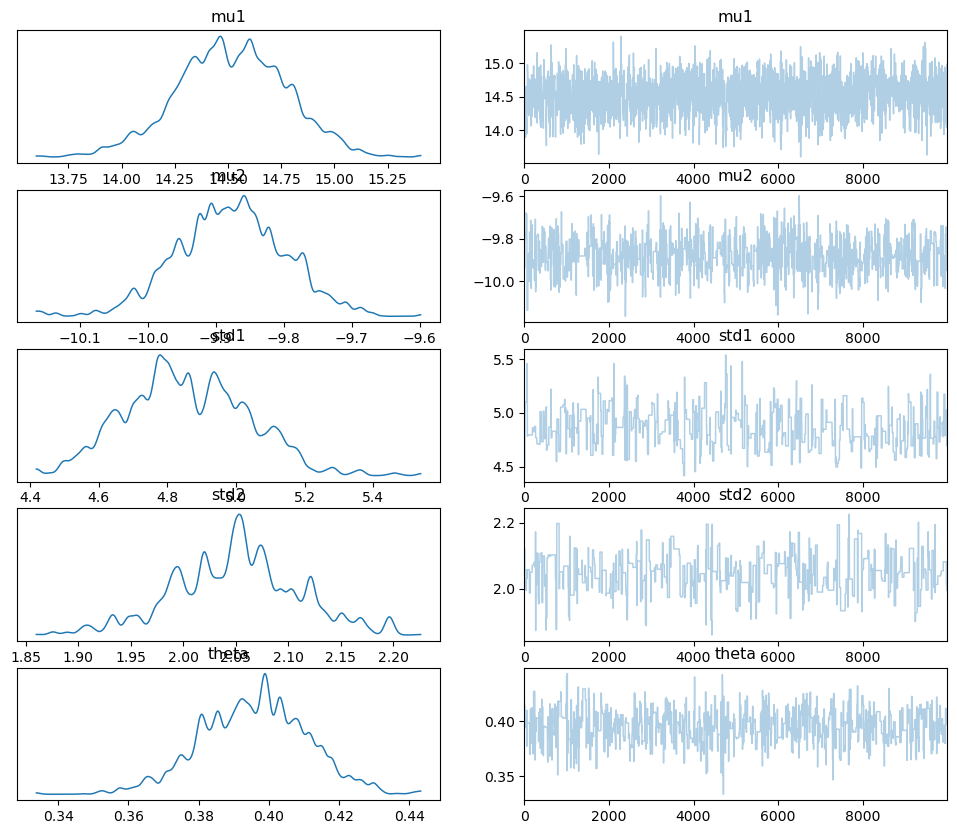

In [220]:
X1_tensor = tt.as_tensor_variable(X1)

with pm.Model() as model:
    # Define priors
    mu1 = pm.Normal('mu1', mu=0, sd=1)
    std1 = pm.HalfNormal('std1', sd=1)
    mu2 = pm.Normal('mu2', mu=0, sd=1)
    std2 = pm.HalfNormal('std2', sd=1)
    theta = pm.Beta('theta', alpha=2, beta=2)

    # Define the two normal distributions
    norm1 = pm.Normal.dist(mu=mu1, sd=std1)
    norm2 = pm.Normal.dist(mu=mu2, sd=std2)

    # Define likelihood
    likelihood = pm.Mixture('likelihood', w=[theta, 1-theta], comp_dists=[norm1, norm2], observed=X1_tensor)

    # Inference using MH
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=100, chains=1, step=step)

# Plot the results
pm.plot_trace(trace)

In [221]:
# Get the trace values for the parameters
trace_mu1 = trace['mu1']
trace_mu2 = trace['mu2']
trace_std1 = trace['std1']
trace_std2 = trace['std2']
trace_theta = trace['theta']

# Transform them back to the original scale

np.max([trace_mu1, trace_mu2, trace_std1, trace_std2, trace_theta], axis=1)

array([15.40680471, -9.59803008,  5.53929835,  2.22619301,  0.44337801])

## Gibbs Sampling

The conditional distribution of the target distribution is too hard to compute. Not a good approach for this setup.

### Hamiltonian Monte Carlo Sampling

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta, std2, mu2, std1, mu1]


Sampling 1 chain for 200 tune and 10_000 draw iterations (200 + 10_000 draws total) took 117 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


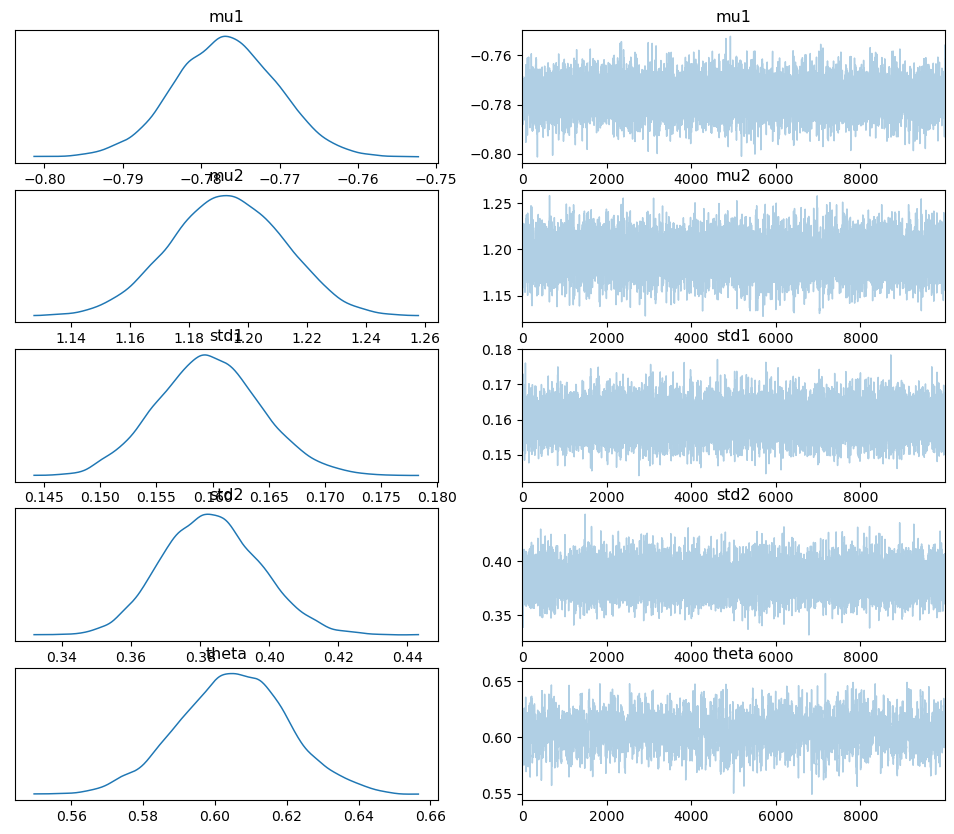

In [224]:
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(np.array(X1).reshape(-1, 1)).flatten()
X1_tensor = tt.as_tensor_variable(X1_scaled)

with pm.Model() as model:
    # Define priors
    mu1 = pm.Normal('mu1', mu=0, sd=1)
    std1 = pm.HalfNormal('std1', sd=1)
    mu2 = pm.Normal('mu2', mu=0, sd=1)
    std2 = pm.HalfNormal('std2', sd=1)
    theta = pm.Beta('theta', alpha=2, beta=2)

    # Define the two normal distributions
    norm1 = pm.Normal.dist(mu=mu1, sd=std1)
    norm2 = pm.Normal.dist(mu=mu2, sd=std2)

    # Define likelihood
    likelihood = pm.Mixture('likelihood', w=[theta, 1-theta], comp_dists=[norm1, norm2], observed=X1_tensor)

    # Inference using HMC
    trace = pm.sample(10000, tune=100, chains=1, target_accept=0.95)

    # Plot the results
    pm.plot_trace(trace)

In [231]:
# Get the trace values for the parameters
trace_mu1 = trace['mu1']
trace_mu2 = trace['mu2']
trace_std1 = trace['std1']
trace_std2 = trace['std2']
trace_theta = trace['theta']

# Transform them back to the original scale
original_trace_mu1 = trace_mu1 * scaler.scale_ + scaler.mean_
original_trace_mu2 = trace_mu2 * scaler.scale_ + scaler.mean_
original_trace_std1 = trace_std1 * scaler.scale_
original_trace_std2 = trace_std2 * scaler.scale_

np.max([original_trace_mu1, original_trace_mu2, original_trace_std1, original_trace_std2, trace_theta], axis=1)

array([-9.9469316 , 15.38585992,  2.05339462,  4.93002937,  0.60503746])

### Variational Inference
#### Automatic Differentiation

Finished [100%]: Average Loss = 677.43


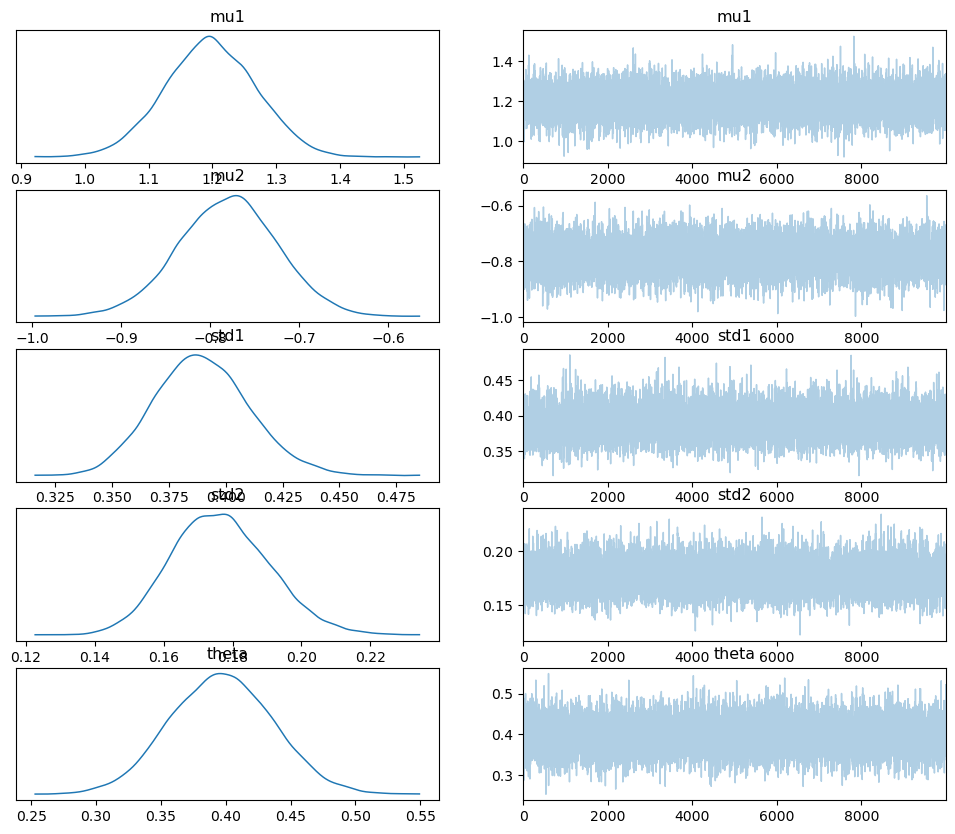

In [237]:
# Assume posterior distribution can be approximated with a multivariate gaussian distribution
# i.e. this method only works well with at most close to unimodal posteriors
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(np.array(X1).reshape(-1, 1)).flatten()
X1_tensor = tt.as_tensor_variable(X1_scaled)

with pm.Model() as vae:    
    # Define variational families of latent variables and set initial parameter values
    mu1 = pm.Normal('mu1', mu=0, sd=1)
    std1 = pm.HalfNormal('std1', sd=1)
    mu2 = pm.Normal('mu2', mu=0, sd=1)
    std2 = pm.HalfNormal('std2', sd=1)
    theta = pm.Beta('theta', alpha=2, beta=2)

    # Define the two normal distributions
    norm1 = pm.Normal.dist(mu=mu1, sd=std1)
    norm2 = pm.Normal.dist(mu=mu2, sd=std2)

    # Define likelihood
    likelihood = pm.Mixture('likelihood', w=[theta, 1-theta], comp_dists=[norm1, norm2], observed=X1_tensor)
    
    with vae:
        # Perform approximate inference 
        # by minimizing -ELBO using the parameters of latent variables
        approx = pm.fit(n=20000, method='advi')

    # Sample from the approximate posterior
    trace = approx.sample(draws=10000)

    # Plot the posterior
    pm.plot_trace(trace)

In [238]:
# Get the trace values for the parameters
trace_mu1 = trace['mu1']
trace_mu2 = trace['mu2']
trace_std1 = trace['std1']
trace_std2 = trace['std2']
trace_theta = trace['theta']

# Transform them back to the original scale
original_trace_mu1 = trace_mu1 * scaler.scale_ + scaler.mean_
original_trace_mu2 = trace_mu2 * scaler.scale_ + scaler.mean_
original_trace_std1 = trace_std1 * scaler.scale_
original_trace_std2 = trace_std2 * scaler.scale_

np.mean([original_trace_mu1, original_trace_mu2, original_trace_std1, original_trace_std2, trace_theta], axis=1)

array([15.4297934 , -9.99397225,  5.00910089,  2.27066365,  0.39670666])

In [239]:
np.max([original_trace_mu1, original_trace_mu2, original_trace_std1, original_trace_std2, trace_theta], axis=1)

array([19.65532459, -7.21549975,  6.24108113,  3.01349986,  0.54965643])

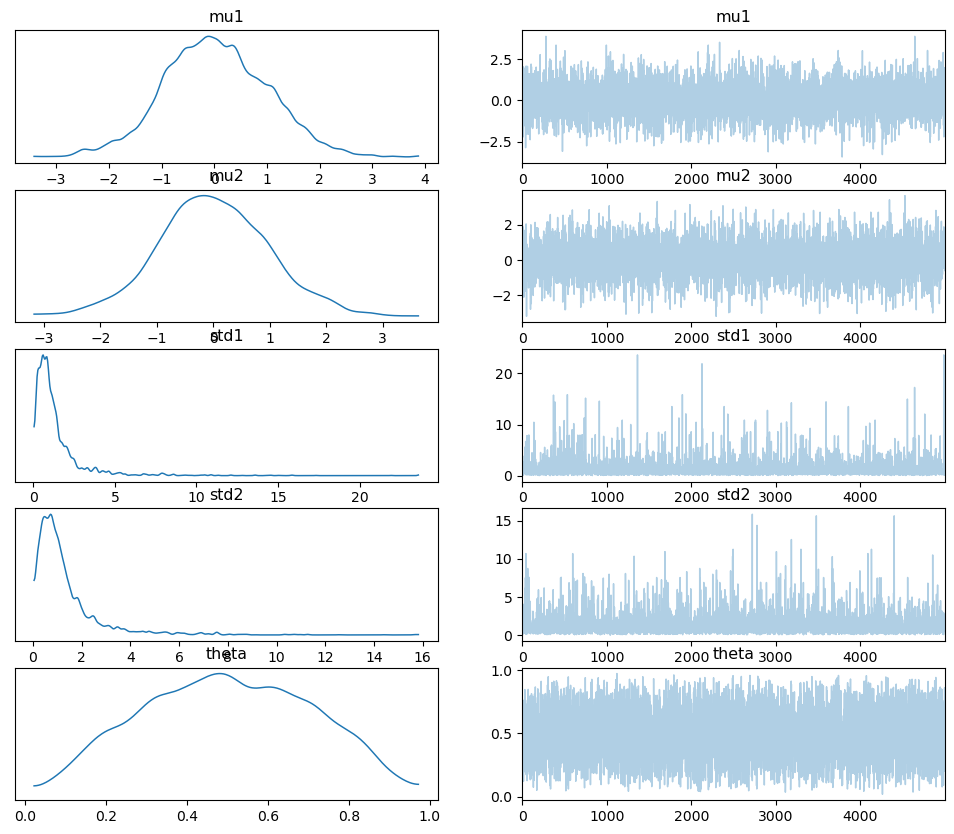

In [15]:
with pm.Model() as vae:
    # Define priors
    mu1 = pm.Normal('mu1', mu=0, sd=1)
    std1 = pm.HalfNormal('std1', sd=1)
    mu2 = pm.Normal('mu2', mu=0, sd=1)
    std2 = pm.HalfNormal('std2', sd=1)
    theta = pm.Beta('theta', alpha=2, beta=2)

    # Define the two normal distributions
    norm1 = pm.Normal.dist(mu=mu1, sd=std1)
    norm2 = pm.Normal.dist(mu=mu2, sd=std2)

    # Define likelihood
    likelihood = pm.Mixture('likelihood', w=[theta, 1-theta], comp_dists=[norm1, norm2], observed=X1_tensor)
    
    with vae:
        # Perform approximate inference
        approx = pm.fit(300, method="svgd",
            inf_kwargs=dict(n_particles=5000),
            obj_optimizer=pm.sgd(learning_rate=0.0001))

    # Sample from the posterior
    trace = approx.sample(draws=5000)

    # Plot the posterior
    pm.plot_trace(trace)

In [16]:
# Get the trace values for the parameters
trace_mu1 = trace['mu1']
trace_mu2 = trace['mu2']
trace_std1 = trace['std1']
trace_std2 = trace['std2']
trace_theta = trace['theta']

# Transform them back to the original scale
original_trace_mu1 = trace_mu1 * scaler.scale_ + scaler.mean_
original_trace_mu2 = trace_mu2 * scaler.scale_ + scaler.mean_
original_trace_std1 = trace_std1 * scaler.scale_
original_trace_std2 = trace_std2 * scaler.scale_

np.max([original_trace_mu1, original_trace_mu2, original_trace_std1, original_trace_std2, trace_theta], axis=1)

array([ 0.39645939,  0.08934724, 17.2984035 , 16.72018667,  0.4997668 ])